In [1]:
# ################################################################
# Importing libraries
# ################################################################
import os
import numpy as np
import sys
import typing
from osgeo import gdal
import tensorflow as tf
from tensorflow import keras
from skimage import exposure
from tensorflow.keras import  layers, models, Model, Input
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt

In [2]:
# ################################################################
# Define dataset directory
# ################################################################
BASE_PATH = "/home/jovyan/private/Research_Paper"
INPUT_PATH = os.path.join(BASE_PATH, "dataset")
INPUT_PATH = os.path.join(INPUT_PATH, "FCN")
RS_PATH = os.path.join(INPUT_PATH, "raw_image")
GFM_PATH = os.path.join(INPUT_PATH, "raw_gfm")
LABEL_PATH = os.path.join(INPUT_PATH, "ground_truth")
OUTPUT_PATH = os.path.join(BASE_PATH, "network")
DATA_PATH = os.path.join(BASE_PATH, "ouput")

In [3]:
# ################################################################
# Loading input data
#
# images: contains the 6-band image (6D array)
# labels: contains 1D arrays in which each pixel is assigned with 
#         a label "0" = slum and "1" = other
# ################################################################

def gtiff_to_array(file_path):
    """Takes a file path and returns a tif file as a 3-dimensional numpy array, width x height x bands."""
    data = gdal.Open(file_path)
    bands = [data.GetRasterBand(i+1).ReadAsArray() for i in range(data.RasterCount)]
    return np.stack(bands, axis=2)


def fetch_tiles(path):
    """Parse the images into a dictionary of numpy arrays.
    """
    tiles = {}
    for f in sorted(os.listdir(path)):
        fdir = os.path.join(path, f)
        _, ext = os.path.splitext(f)
        if ext.lower() == ".tif":
            imgtype = f[:-4]
            tiles[imgtype] = gtiff_to_array(fdir)
    return tiles

Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_3002/3613631479.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)
/tmp/ipykernel_3002/3613631479.py:49: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = data.astype(np.float)


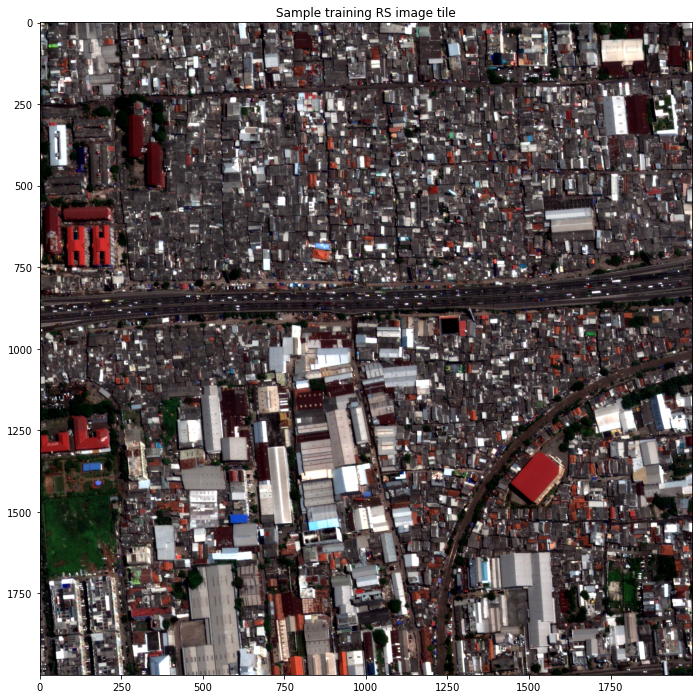

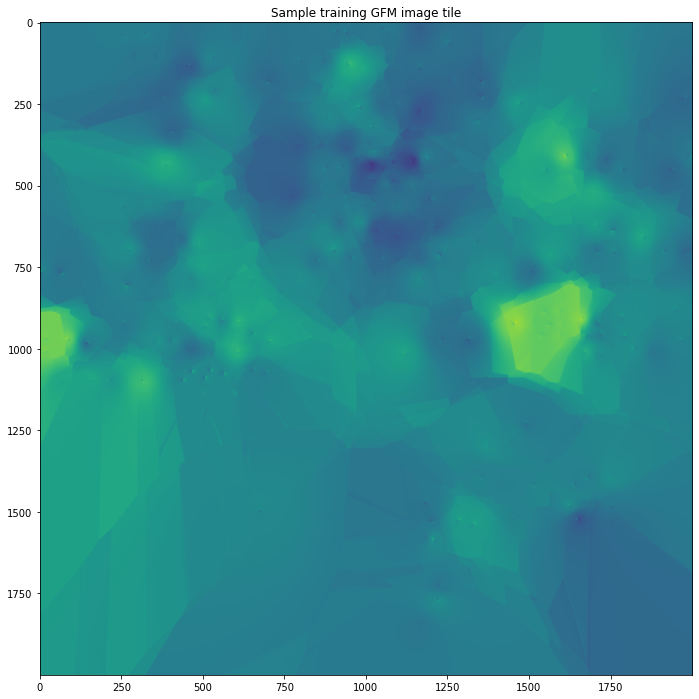

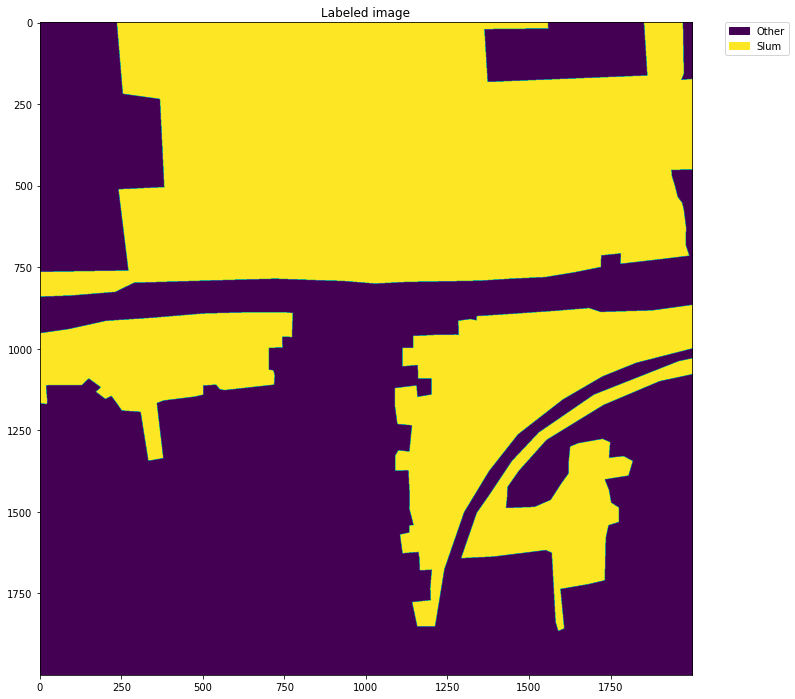

In [4]:
# ################################################################
# Visualize some sample input data
# ################################################################

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
import matplotlib.patches as mpatches

def visualize_labels(labels,title, fig_width=15, fig_height=12):
    """Visualize the labels prepared from the reference images."""
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    values = np.unique(labels.ravel())
    im = plt.imshow(labels[:,:,0])
    a.set_title("Labeled image")
    # get the colors of the values, according to the 
    # colormap used by imshow
    colors = [im.cmap(im.norm(value)) for value in values]
    # create a patch (proxy artist) for every color 
    labels = ["Other", "Slum"]
    patches = [mpatches.Patch(color=colors[i], label=j) for i, j in zip(range(len(values)), labels)]
    # put those patched as legend-handles into the legend
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


def visualize_RS(data, title, fig_width=15, fig_height=12):
    """Visualize the satellite image data."""
    # visualize only RGB bands
    data = data[:, :, 0:-1]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(np.float)
    # perform stretching for better visualization
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

    
def visualize_GFM(data, title, fig_width=15, fig_height=12):
    """Visualize the feature map."""
    # visualize single bands
    data = data[:, :, 0:1]
    data = data.astype(np.float)
#     # perform stretching for better visualization
#     for i in range(data.shape[2]):
#         p2, p98 = np.percentile(data[:, :, i], (2, 98))
#         data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
#                                                       in_range=(p2, p98))
    fig = plt.figure(figsize=(fig_width, fig_height))
    a=fig.add_subplot(1,1,1)
    a.set_title(title)
    plt.imshow(data)

    
RS_image_tiles = fetch_tiles(RS_PATH)
GFM_image_tiles = fetch_tiles(GFM_PATH)
label_tiles = fetch_tiles(LABEL_PATH)

visualize_RS(RS_image_tiles["area3"], "Sample training RS image tile")
visualize_GFM(GFM_image_tiles["area3"], "Sample training GFM image tile")
visualize_labels(label_tiles["area3"],  "Sample training label image tile")

In [5]:
# ################################################################
# Generating patches of the input data
# ################################################################

# RS_image_tiles = fetch_tiles(RS_PATH)/255  # normalizing the RS data

PATCHSIZE = 125
NBANDS = RS_image_tiles["area3"].shape[-1]

def gridwise_sample(imgarray, patchsize):
    """Extract sample patches of size patchsize x patchsize from an image (imgarray) in a gridwise manner.
    """
    nrows, ncols, nbands = imgarray.shape
    patchsamples = np.zeros(shape=(0, patchsize, patchsize, nbands),
                            dtype=imgarray.dtype)
    for i in range(int(nrows/patchsize)):
        for j in range(int(ncols/patchsize)):
            tocat = imgarray[i*patchsize:(i+1)*patchsize,
                             j*patchsize:(j+1)*patchsize, :]
            tocat = np.expand_dims(tocat, axis=0)
            patchsamples = np.concatenate((patchsamples, tocat),
                                          axis=0)
    return patchsamples

RS_Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, NBANDS), dtype=np.float32)
GFM_Xtrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 32), dtype=np.float32)
Ytrain = np.zeros(shape=(0, PATCHSIZE, PATCHSIZE, 1), dtype=np.uint8)

# sample each training tile systematically in a gridwise manner
train_areas = ["area1","area2","area4","area6", "area8", "area9", "area11", "area13", "area14", "area10"]
test_areas = ["area3","area7","area12"]
for area in train_areas:
    RS_X_toadd = gridwise_sample(RS_image_tiles[area], PATCHSIZE)
    GFM_X_toadd = gridwise_sample(GFM_image_tiles[area], PATCHSIZE)
    Y_toadd = gridwise_sample(label_tiles[area], PATCHSIZE)
    RS_Xtrain = np.concatenate((RS_Xtrain, RS_X_toadd), axis=0)
    GFM_Xtrain = np.concatenate((GFM_Xtrain, GFM_X_toadd), axis=0)
    Ytrain = np.concatenate((Ytrain, Y_toadd), axis=0)

# encode all non-informal settlement classes as one class
Ytrain[Ytrain!=2] = 1
print("There are %i number of training patches" % (RS_Xtrain.shape[0]))
print("There are %i number of training patches" % (GFM_Xtrain.shape[0]))

# making single input for training the model
Xtrain = [RS_Xtrain,GFM_Xtrain]

There are 2560 number of training patches
There are 2560 number of training patches


#### Setting up the network

In [6]:
# ################################################################
# Prerequisites for the network
#
# Includes a few helper functions which will be used to create and
# evaluate the network, the training and the accuracy.
# ################################################################

import imp, h5py
import dill, pickle
imp.reload(h5py)

from tensorflow.python.keras import backend as K
sess = K.get_session()

from tensorflow.compat.v1.keras.backend import set_session


# Tensorflow configuration
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.compat.v1.Session(config=config))

# Helper functions for the networks
def to_categorical_4d(y, nc):
    """Convert a reclassed ground truth array to one-hot encoding
    
    Keyword arguments:
    y -- ground truth image
    nc -- number of classes
    """
    Y = np.zeros((y.shape[0],
                  y.shape[1],
                  y.shape[2],
                  nc),
                  dtype=np.int32)
    for h in range(y.shape[0]):
        for i in range(y.shape[1]):
            for j in range(y.shape[2]):
                if y[h, i, j, 0] != 0:
                    Y[h, i, j, y[h, i, j, 0]-1] = 1
                else:
                    continue
    return Y


def train(model, data, labels, epochs, batch_size, validation_split, callbacks, verbosity=2):
    """Fits training and label data into a model of a network

    :param model: Network
    :param data: Input data (aerial view of the images)
    :param labels: Classified input data (classified images)
    :param epochs: The number of epochs/iterations
    :param batch_size: The batch size per epoch
    :param validation_split: relative split of the validation set
    :param verbosity: Verbosity level of the output [default: 2] (0 = silent, 1 = progress bar, 2 = line per epoch)
    :return: Training history
    """
    history = model.fit(
        x=data,
        y=labels,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbosity,
        validation_split=validation_split,
        callbacks=[checkpoint, early],
    ) # call, early, lr_sched
    return history

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# ################################################################
# Helper functions - import/export of network
#
# These two functions help to export the network and import it.
# That allows to skip the training at a later stage.
# ################################################################

class ModelHistory:
    """Just a small container class to hold relevant information of a trained
    model.
    """

    def __init__(self, uuid, name, model, history, readme):
        """Create a new instance of this class
        :param uuid: A unique identifier of the network
        :param name: The networks name
        :param model: The pretrained model
        :param history: The training history of the model
        :param readme: A small readme with a summary of training parameters
        """
        self.uuid = uuid
        self.name = name
        self.model = model
        self.history = history
        self.readme = readme

def get_file_names(uuid, name):
    """Generates three file names for the model, weights and history file and
    the networks readme.

    File name order of returned tuple:
        * readme
        * model
        * weights
        * history

    :param uuid: Universal unique identifier of a trained network
    :param name: The networks name
    :return: Tuple with files in the order mentioned above
    """
    base = f"{OUTPUT_PATH}/{str(uuid)}-{name}"

    f_readme = f"{base}-readme.txt"
    f_model = f"{base}-model.h5"
    f_weights = f"{base}-weights.h5"
    f_history = f"{base}-history"

    return (f_readme, f_model, f_weights, f_history)


def export_model(m: ModelHistory):
    """If a model is sufficiently trained, it can be exported. This allows to
    simply save the models state and the training history. Whenever one want to
    use the model the next time, the training can be skipped, since the trained
    model can just be imported from files.

    :param model_history: The trained model and history to be stored
    """
    f_readme, f_model, f_weights, f_history = get_file_names(m.uuid,m.name)

    # save readme
    with open(f_readme, 'w') as f:
        f.write(m.readme)
    print(f"Exported README: {f_readme}")

    # save models & weights
    m.model.save(f_model)
    print(f"Exported model: {f_model}")
    m.model.save_weights(f_weights)
    print(f"Exported weights: {f_weights}")

    # save history
    with open(f_history, "wb") as f:
        pickle.dump(m.history, f)
    print(f"Exported history: {f_history}")

def import_model(uuid, name):
    """Previously exported models can be imported with this funciton.
    :param uuid: The networks uuid
    :param name: The networks name
    :return: Instance of ModelHistory
    """
    f_readme, f_model, f_weights, f_history = get_file_names(uuid, name)

    # Load readme
    with open(f_readme, 'r') as f:
        readme = "".join(f.readlines())
    print(f"Imported README: {f_readme}")

    # Load model & weights
    model = tf.keras.models.load_model(f_model)
    print(f"Imported model: {f_model}")
    model.load_weights(f_weights)
    print(f"Imported weights: {f_weights}")

    # Load history
    with open(f_history, 'rb') as f:
        history = pickle.load(f)
    print(f"Imported history: {f_history}")

    return ModelHistory(uuid, name, model, history, readme)

2022-01-04 19:24:43.549315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/lib/jvm/java-11-openjdk-amd64/lib/server:/opt/hadoop/lib/native:/usr/local/lib/R/lib:/usr/local/grass78/lib
2022-01-04 19:24:43.550090: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-04 19:24:44.020626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are instal

In [7]:
# ################################################################
# Network builder functions
#
# ################################################################

from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Convolution2D, LeakyReLU, Reshape
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Concatenate


def built_saimese(i,j,k,nclasses):

#####################

# Convolution block-1

######################
    input1 = Input(shape=(i,j,k))
    layer = ZeroPadding2D((2, 2))(input1)
    layer = Convolution2D(
              filters=16,
              kernel_size=(5, 5),
              dilation_rate=(1, 1))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((2, 2))(layer)
    layer = MaxPooling2D(
              pool_size=(5, 5),
              strides=(1, 1))(layer)
################################################
#     input2 = Input(shape=(i,j,k+28))

#     merge = layers.concatenate([layer, input2])
################################################

#####################

# Convolution block-2

######################

    layer = ZeroPadding2D((4, 4))(layer)
    # layer = ZeroPadding2D((4, 4))(merge)
    layer = Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(2, 2))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((4, 4))(layer)
    layer = MaxPooling2D(
            pool_size=(9, 9),
            strides=(1, 1))(layer)
###############################################
    input2 = Input(shape=(i,j,k+28))

    merge = layers.concatenate([layer, input2])
###############################################

#####################

# Convolution block-3

######################

    # layer = ZeroPadding2D((6, 6))(layer)
    layer = ZeroPadding2D((6, 6))(merge)
    layer = Convolution2D(
              filters=32,
              kernel_size=(5, 5),
              dilation_rate=(3, 3))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((6, 6))(layer)
    layer = MaxPooling2D(
            pool_size=(13, 13),
            strides=(1, 1))(layer)
###############################################
#     input2 = Input(shape=(i,j,k+28))

#     merge = layers.concatenate([layer, input2])
###############################################

#####################

# Convolution block-4

######################

    layer = ZeroPadding2D((8, 8))(layer)
    # layer = ZeroPadding2D((8, 8))(merge)
    layer = Convolution2D(
            filters=32,
            kernel_size=(5, 5),
            dilation_rate=(4, 4))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((8, 8))(layer)
    layer = MaxPooling2D(
            pool_size=(17, 17),
            strides=(1, 1))(layer)
###############################################
#     input2 = Input(shape=(i,j,k+28))

#     merge = layers.concatenate([layer, input2])
###############################################

#####################

# Convolution block-5

######################

    layer = ZeroPadding2D((10, 10))(layer)
    # layer = ZeroPadding2D((10, 10))(merge)
    layer = Convolution2D(
            filters=32,
            kernel_size=(5, 5),
            dilation_rate=(5, 5))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((10, 10))(layer)
    layer = MaxPooling2D(
            pool_size=(21, 21),
            strides=(1, 1))(layer)
###############################################
#     input2 = Input(shape=(i,j,k+28))

#     merge = layers.concatenate([layer, input2])
################################################

#####################

# Convolution block-6

######################

    layer = ZeroPadding2D((12, 12))(layer)
    # layer = ZeroPadding2D((12, 12))(merge)
    layer = Convolution2D(
            filters=32,
            kernel_size=(5, 5),
            dilation_rate=(6, 6))(layer)
    layer = BatchNormalization(axis=3)(layer)
    layer = LeakyReLU(0.1)(layer)
    layer = ZeroPadding2D((12, 12))(layer)
    layer = MaxPooling2D(
            pool_size=(25, 25),
            strides=(1, 1))(layer)

#####################

# Classification block

######################

##############################################
    layer = Convolution2D(
            filters=nclasses,
            kernel_size=(1, 1))(layer)
##############################################
    layer = Dropout(0.25)(layer)
##############################################
    prediction = keras.layers.Activation(
            activation="softmax")(layer)
    siamese_model = keras.Model(inputs=[input1,input2],outputs=prediction)
    return siamese_model

def build_network(name: str) -> typing.Callable:
    """Builds a new network, based on the network name
    :param name: The networks name
    :return: The builder function of the corresponding network.
    """
    if name.lower() == "saimese_fcndk6":
        return built_saimese
    else:
        print("Mention netwrok name")

#### Configration for the training

In [8]:
# ################################################################
# Fixed constants
#
# This code block does not need to be changed. 
# ################################################################

import uuid

# Execution mode options
SKIP = 0                # Do nothing, e.g. just reloading other variables
TRAIN_NEW = 1           # Create a new model & train it with given parameters
LOAD_AND_TRAIN = 2      # Load existing model & train
LOAD = 3                # Load existing model w/o training 

# Bands and classes do not need to be changed.
NUMBER_BANDS = NBANDS
NUMBER_CLASSES = 2

# Constants relevant for the network & training
NETWORK_UUID = str(uuid.uuid1())

In [9]:
# ################################################################
# Training configuration
#
# These are the variable parameters of the configuration. Change
# them to your prefered configuration and check the results of the
# training at the end of the execution.
# ################################################################

# Define here the exection mode
# Remark: The option LOAD_AND_TRAIN and LOAD require a given UUID and network
#         name. Make sure those are given below
# Allowed Options:
#    * SKIP
#    * TRAIN_NEW
#    * LOAD_AND_TRAIN
#    * LOAD
exec_mode = TRAIN_NEW

# If you set the exec_mode to work with a pretrained network, then define the
# network's UUID and the network's name here. These two parameters are crucial
# to assign the right file's to the network.
load_from_uuid = ""
load_from_name = ""

# Decide whether you want to save the training configuration after the training
# is successful.
# Allowed Options:
#    * True
#    * False
SAVE_AFTER_EXEC = True


# Set the name of the executed network here. Defines the network type
# Allowed values:
#     * Saimese_FCNDK6
NETWORK_NAME = "Saimese_FCNDK6"


# Increases the amount of epochs per training run. An epoch is in principle an
# iteration over the training data. As larger the number of epochs, as better
# the training results. But if the epochs are too large you risk to overfit the
# network.
NUMBER_EPOCHS = 400


# Define the batch size with this parameter.
BATCH_SIZE = 64

# Set here the relative size of the validation set. Generally, this value should
# be small, but if you have a small input data set, you might want to increase
# the validation split.
VALIDATION_SPLIT = 0.30


# Chose the network's optimizer.
# Allowed values:
#    * SGD
#    * Adam
NETWORK_OPTIMIZER = "SGD"

# Define the hyper parameters of the SGD optimizer here.
# Ignore these parameters if you want to train with an Adam optimizer.
SGD_LEARNING_RATE = 0.00001
SGD_MOMENTUM = 0.9

# Define the hyper parameters of the Adam optimizer here.
# Ignore these parameters if you want to train with an SGD optimizer.
ADAM_LEARNING_RATE = 0.1
ADAM_BETA_1 = 0.9
ADAM_BETA_2 = 0.999
ADAM_EPSILON= 1e-07

In [11]:
# ################################################################
# Training of the model
# 
# This section covers the actual training of the model and ensures
# the results are exported and ready for import. The configuration
# should have happened in previous code blocks.
# ################################################################

# This function will be called to build the model
model_builder = build_network(NETWORK_NAME)

# Just build the configuration description of the network
readme = f"""
Training configuration
================================
Network
    UUID:               {NETWORK_UUID}
    Name:               {NETWORK_NAME}
    Optimizer:          {NETWORK_OPTIMIZER}

Parameters
    Bands:              {NUMBER_BANDS}
    Classes:            {NUMBER_CLASSES}
    Epochs:             {NUMBER_EPOCHS}
    Batch Size:         {BATCH_SIZE}
"""

if NETWORK_OPTIMIZER == "SGD":
    readme += f"""
Optimizer (if SGD)
    Learning Rate:      {SGD_LEARNING_RATE}
    Momentum:           {SGD_MOMENTUM}
    """

if NETWORK_OPTIMIZER == "Adam":
    readme += f"""
Optimizer (Adam)
    Learning Rate:      {ADAM_LEARNING_RATE}
    Beta 1:             {ADAM_BETA_1}
    Beta 2:             {ADAM_BETA_2}
    Epsilon:            {ADAM_EPSILON}
    """

readme += f"""
Execution summary
    RS_Patches:         {Xtrain[0].shape[0]}
    GFM_Patches:        {Xtrain[1].shape[0]}
    Validation Split:   {VALIDATION_SPLIT}
    RS_Resolution(px):  {Xtrain[0].shape[1]}x{Xtrain[0].shape[2]}
    GFM_Resolution(px): {Xtrain[1].shape[1]}x{Xtrain[1].shape[2]}
    RS_Bands:           {NUMBER_BANDS}
    GFM_Bands:          {Xtrain[1].shape[3]}
    Classes:            {NUMBER_CLASSES}
    """

readme += "\n"
readme += "Training Set:\n    "
readme += "\n    ".join(tuple(train_areas))

readme += "\n"
readme += "Test Set:\n    "
readme += "\n    ".join(tuple(test_areas))

# Optimizer
if NETWORK_OPTIMIZER == "Adam":
    OPTIMIZER = tf.keras.optimizers.Adam(
        learning_rate=ADAM_LEARNING_RATE,
        beta_1=ADAM_BETA_1, 
        beta_2=ADAM_BETA_2, 
        epsilon=ADAM_EPSILON
    )
elif NETWORK_OPTIMIZER == "SGD":
    OPTIMIZER = tf.keras.optimizers.SGD(
        learning_rate=SGD_LEARNING_RATE, 
        momentum=SGD_MOMENTUM
    )
    
# Process the steps of the required modes
if exec_mode in [TRAIN_NEW]:
    # Building a new network.
    print(f"Build a new network: {NETWORK_UUID} {NETWORK_NAME}")
    model = model_builder(Xtrain[0].shape[1],Xtrain[0].shape[2],NUMBER_BANDS, NUMBER_CLASSES)
    # weights_path = "/home/jovyan/private/Research_Paper/network/checkpoint/weight.123.h5"
    # model.load_weights(weights_path)
    model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy']) #,f1_m,precision_m, recall_m
    model.summary()

    # Defining weight path for callback funtion to save highest val_accuray weights.
    weight_path = os.path.join(OUTPUT_PATH, "checkpoint")
    check_weights = weight_path + "/weight.{epoch}.h5"

    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint(check_weights, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')
    
if exec_mode in [LOAD, LOAD_AND_TRAIN]:
    # Load existing network from files
    print(f"Loaded existing network: {NETWORK_UUID} {NETWORK_NAME}")
    m = import_model(NETWORK_UUID, NETWORK_NAME)
    readme = m.readme
    model = m.model
    history = m.history

# Print configuration README before (possible) training
print(readme)

if exec_mode in [TRAIN_NEW, LOAD_AND_TRAIN]:
    # Train the network
    Ytrain = to_categorical_4d(Ytrain, NUMBER_CLASSES)
    # initial_history = model.fit(Xtrain, Ytrain, epochs=99,callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10 ** (epoch / 30))])   # Uncomment this line for training a model to finds the optimal learning rate
    history = train(model, Xtrain, Ytrain, NUMBER_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT, callbacks=[checkpoint, early]).history # call, early, lr_sched

if exec_mode in [TRAIN_NEW, LOAD, LOAD_AND_TRAIN]:
    if SAVE_AFTER_EXEC:
        export_model(ModelHistory(
            NETWORK_UUID, NETWORK_NAME, model, history, readme
        ))

if exec_mode in [SKIP]:
    print("Remark: Execution mode is 'SKIP'; Nothing executed in this code block")

Build a new network: 96f94de0-6d8b-11ec-96c6-02420a0001f4 Saimese_FCNDK6
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 125, 125, 4  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 129, 129, 4)  0          ['input_3[0][0]']                
 2D)                                                                                              
                                                                                                  
 conv2d_7 (Conv2D)              (None, 125, 125, 16  1616        ['zero_padding2d_12[0][0]']      
                   

In [ ]:
# ################################################################
# Learning curves
#
# To verify the optimal learning rate for the algorithm, we can plot learning
# curves. Three functions are plotted:
#
#   * loss function
#   * error rate function
#   * learning rate
# ################################################################

plt.plot(np.arange(1, 100), initial_history.history['loss'], label='Loss', lw=3)
plt.plot(np.arange(1, 100), initial_history.history['accuracy'], label='Accuracy', lw=3)
plt.plot(np.arange(1, 100), initial_history.history['lr'], label='Learning rate', color='#000', lw=3, linestyle='--')
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

In [ ]:
# ################################################################
# Learning curves
#
# To verify the optimal learning rate for the algorithm, we can plot learning
# curves. Funtion is plotted:
#
#   * loss function vs Learning rate
# ################################################################
learning_rates = 1e-6 * (10 ** (np.arange(99) / 30))
plt.semilogx(learning_rates, initial_history.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

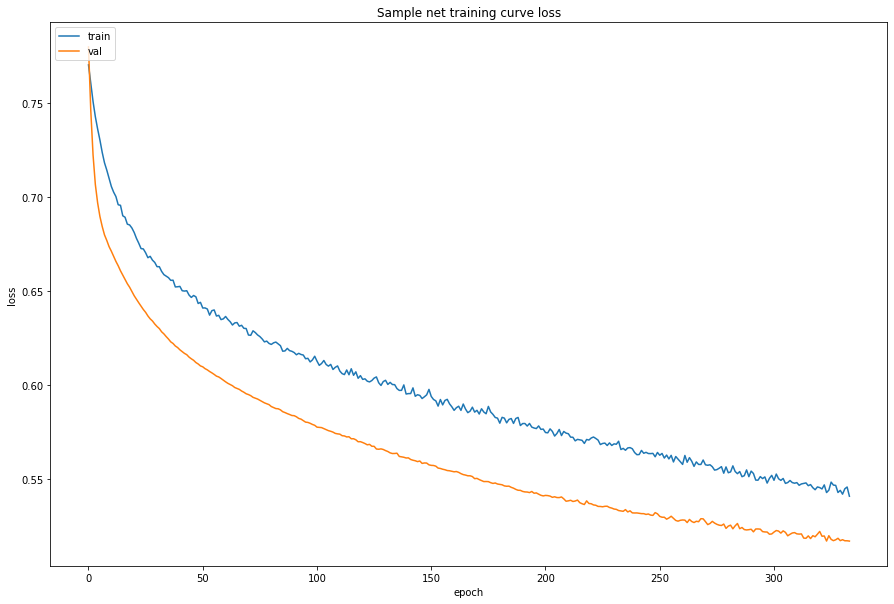

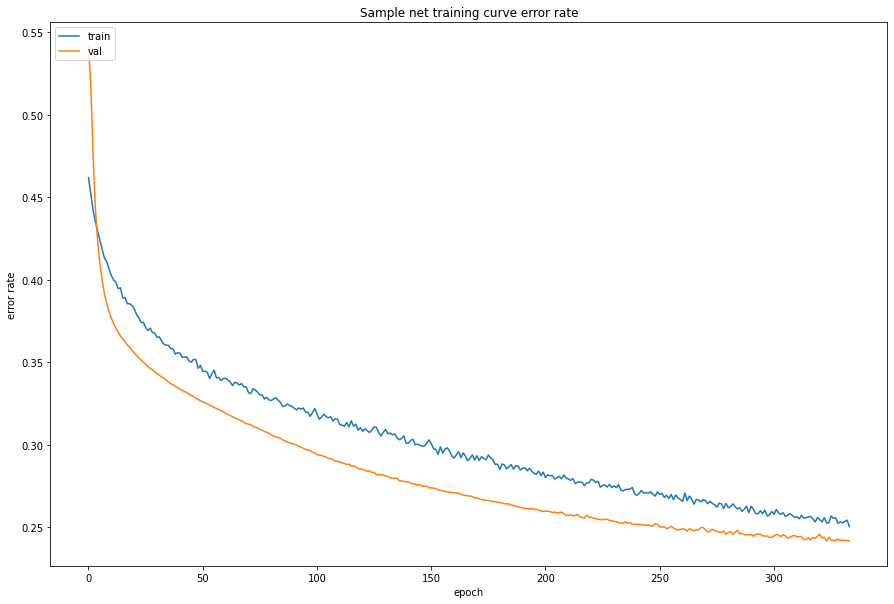

In [12]:
# ################################################################
# Learning curves
#
# To verify whether the algorithm is working, we can plot learning
# curves. Two functions are plotted:
#
#   * loss function
#   * error rate function
# ################################################################

# plot learning curve
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Sample net training curve loss")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()
plt.plot(1-np.array(history["accuracy"]))
plt.plot(1-np.array(history["val_accuracy"]))
plt.title("Sample net training curve error rate")
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel("error rate")
plt.xlabel("epoch")
plt.show()

#### Accuracy assessment

In [13]:
# ################################################################
# 
# Previously, the input data was split into training & test data.
# The test data is used right now. The 4 band image is used to 
# predict a classificaiton. The predicted classification will be
# compared to the original classification of the input data.
# 
# This procedure allows a simulated test run of the neural network.
# Since we already have the expected classification, we can
# evaluate the accuracy of the network.
# ################################################################

from matplotlib import pyplot

def evaluate_predictions(
    input_: np.ndarray,
    nclasses: int,
    f_weights: str,
    optimizer: tf.keras.optimizers.Optimizer,
    model_builder: typing.Callable,
) -> np.ndarray:
    """Takes an input image, patches it into smaller patches and feeds the FCN
    with each of the patches. The output samples are patches of the predicted
    classification. These patches are combined into one large image, that can
    be compared with the classified image of the corresponding input data.

    :param input: test image to evaluate
    :param nc: Number of classes/labels
    :param f_weights: File path to the corresponding weights file
    :param optimizer: Optimizer for the network
    :param model_build: method to create the model
    :return: 2D ndarray of the predicted labels
    """
    x = Xtest[0].shape[0]
    y = Xtest[0].shape[1]
    bands = Xtest[0].shape[2]

    # Build model and load model weights
    model = model_builder(x, y, bands, nclasses)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics='accuracy')
    model.load_weights(f_weights)

    # Predict field boundaries in network
    # Increase dimension to perform batch prediction
    input_1 = np.expand_dims(input_[0], 0)
    input_2 = np.expand_dims(input_[1], 0)
    input_= [input_1,input_2]
    prediction = model.predict(input_)[0]
    
    # Map highest score onto label
    prediction = np.argmax(prediction, axis=2) + 1
    
    return prediction

def print_map(labels: np.ndarray, title: str):
    """Will print output based on given input labels.

    Coloring:
        Label 1 = other = black
        Label 2 = slum = white
    
    Remark: The expected data structure is a 2 dimensional array with the int
            value of the corresponding label.

    :param labels: The 2D array of labels per pixel
    :param title: The plot title
    """
    # Create image in RGB
    x, y = labels.shape[0], labels.shape[1]
    img = np.zeros((x, y, 3), dtype=np.uint8)

    for i in range(img.shape[2]):
        img[:, :, i] = np.where(labels[:, :] == 2, 255, 0)

    # Draw plot
    fig = pyplot.figure(figsize=(7, 7))
    pyplot.imshow(img)
    pyplot.suptitle(title)
    pyplot.show()

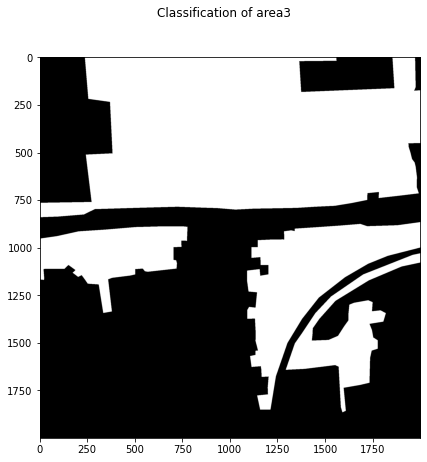

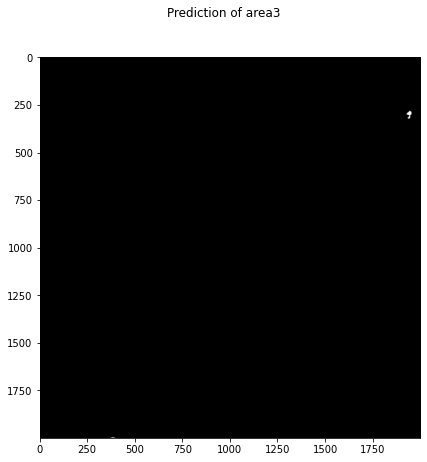

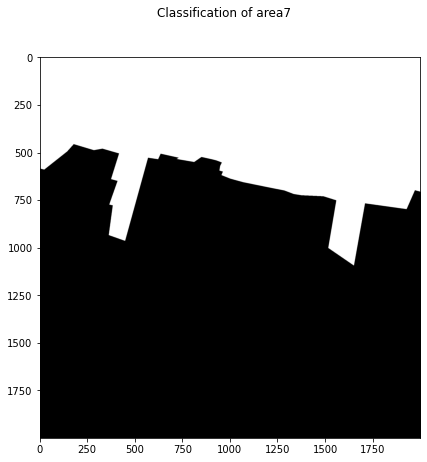

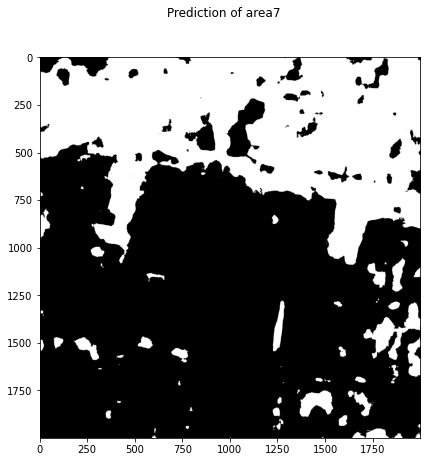

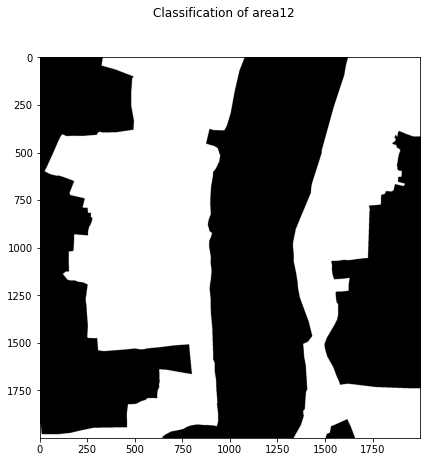

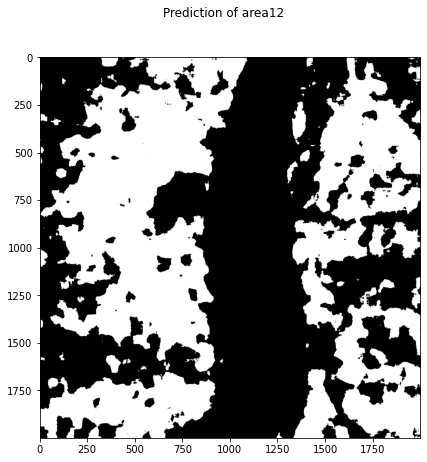

In [14]:
# ################################################################
# Evaluation of the test data
#
# In this step, the previously created test data set is feeded to
# the network. The network responds with a prediciton of field
# boundaries. The resulting data will be used to assess the 
# accuracy of the network.
# ################################################################

predictions = dict()
test_areas = ["area3","area7","area12"]
for tile in test_areas:
    RS_Xtest = RS_image_tiles[tile]
    GFM_Xtest = GFM_image_tiles[tile]
    Xtest = [RS_Xtest, GFM_Xtest]
    Ytest = label_tiles[tile]

    (_, _, f_weights, _) = get_file_names(NETWORK_UUID, NETWORK_NAME)
    result = evaluate_predictions(
        Xtest,
        NUMBER_CLASSES,
        f_weights,
        OPTIMIZER,
        model_builder,
    )

    predictions[tile] = result

    label = np.reshape(Ytest, result.shape)

    print_map(label, f"Classification of {tile}")
    print_map(result, f"Prediction of {tile}")

In [15]:
# ################################################################
# Accuracy 
# ################################################################

import pandas
from IPython.display import display

def get_binary_confusion_matrix(pred, exp):
    """Compute the confusion matrix.

    A confusion matrix is a matrix of the size n x n, where n is the number of
    different labels. In this case, the number of different labels is 2, thus we
    only cover the confusion matrix of a binary classification.

    The matrix can look something as in the example below:

            expected    | other          | field boundaries
    predicted           |                |
    --------------------|----------------|-----------------
    other               | true negative  | false negative
    field-boundaries    | false positive | true positive

    However, this function does not return a matrix, but only the corresponding
    sum of different values. The tuple returns values in this specific order:
        * true positive
        * false positive
        * false negative
        * true negative

    :param pred: ndarray with the predicted classes
    :param exp: preclassified data of the input images
    :return: A tuple of values that represent the confusion matrix
    """
    if exp.size != pred.size:
        raise ValueError("Invalid sizes of prediction and label input")

    exp = np.where(exp[:, :] == 2, True, False)
    pred = np.where(pred[:, :] == 2, True, False)

    tp, fp, fn, tn = 0, 0, 0, 0
    tp = np.sum(np.logical_and(exp, pred))
    fp = np.sum(np.logical_and(np.logical_not(exp), pred))
    fn = np.sum(np.logical_and(exp, np.logical_not(pred)))
    tn = np.sum(np.logical_and(np.logical_not(exp), np.logical_not(pred)))

    return (tp, fp, fn, tn)


def print_binary_confusion_matrix(title, tp, fp, fn, tn):
    """Prints a nice little table of the confusion matrix

    :param title: The title of the confusion matrix
    :param tp: number of true positives
    :param fp: number of false positives
    :param fn: number of false negatives
    :param tn: number of true negatives
    """
    cm = [tp, fp, fn, tn]
    total = sum(cm)
    # percentages
    #(ptp, pfp, pfn, ptn) = tuple([int(100 * cm[i]) for i in range(len(cm))])
    (ptp, pfp, pfn, ptn)= tuple([100 * cm[i] / total for i in range(len(cm))])

    header_row = ["Actual Other", "Actual Slum", "Sum"]
    header_col = ["Prediction Other", "Prediction Slum", "Sum"]

    data = [
        [f"{tn} ({round(ptn, 3)}%)", f"{fn} ({round(pfn, 3)}%)", tn + fn],
        [f"{fp} ({round(pfp, 3)}%)", f"{tp} ({round(ptp, 3)}%)", fp + tp],
        [tn + fp, fn + tp, ""]
    ]

    df = pandas.DataFrame(data, header_col, header_row)
    print(f"Confusion Matrix: {title}")
    print("=" * 32)
    display(df)
    print("\n" * 3)


def print_scores(title, tp, fp, fn, tn):
    """Calculates and prints the typical precision scores of a machine learning
    algorithm.

    :param title: Title to be printed
    :param tp: number of true positives
    :param fp: number of false positives
    :param fn: number of false negatives
    :param tn: number of true negatives
    """
    total = sum([tp, fp, fn, tn])
    # Accuracy
    # How many pixels are classified correctly?
    accuracy = (tp + tn) / total

    # Precision / Specification
    # How accurate can the network determine field boundaries?
    precision = tp / (tp + fp)

    # Recall / Sensitivity
    # How many boundaries did we detect out of all actual field boundary pixels?
    recall = tp / (tp + fn)

    # F1 score
    # harmonic mean of recall & precision
    f1 = ( 2 * ( precision * recall ) ) / ( precision + recall )


    accuracy *= 100
    precision *= 100
    recall *= 100
    f1 *= 100

    print(f"Accuracy Assessment: {title}")
    print("=" * 32)
    print("{:<32} {:<10} %".format("Overall Accuracy", round(accuracy, 3)))
    print("{:<32} {:<10} %".format("Precision", round(precision, 3)))
    print("{:<32} {:<10} %".format("Recall", round(recall, 3)))
    print("{:<32} {:<10} %".format("F1 Score", round(f1, 3)))
    print("\n" * 3)


def run_accuracy_assessment():
    """Simply performs an accuracy assessment based on the entire test data set
    and the results of the evaluation.
    """
    #        tp fp fn tn
    total = [0, 0, 0, 0]

    for k, p in predictions.items():
        # k = key, l = label, p = prediction
        label_tiles["k"] = fetch_tiles(RS_PATH)
        Ytest = label_tiles[k]
             
        l = np.reshape(Ytest, p.shape)
        cm = get_binary_confusion_matrix(p, l)
        (tp, fp, fn, tn) = cm

        # Cumulate values
        for i in range(len(total)):
            total[i] += cm[i]
              
        # Print confusion matrix
        print_binary_confusion_matrix(f"{k}", tp, fp, fn, tn)
        print_scores(f"{k}", tp, fp, fn, tn)


    (tp, fp, fn, tn) = tuple(total)
    print_binary_confusion_matrix("Cumulated", tp, fp, fn, tn)
    print_scores("Cumulated", tp, fp, fn, tn)


run_accuracy_assessment()

Confusion Matrix: area3


,Actual Other,Actual Slum,Sum
Prediction Other,2106343 (52.659%),1893052 (47.326%),3999395
Prediction Slum,57 (0.001%),548 (0.014%),605
Sum,2106400,1893600,






Accuracy Assessment: area3
Overall Accuracy                 52.672     %
Precision                        90.579     %
Recall                           0.029      %
F1 Score                         0.058      %




Confusion Matrix: area7


,Actual Other,Actual Slum,Sum
Prediction Other,2437507 (60.938%),149628 (3.741%),2587135
Prediction Slum,209512 (5.238%),1203353 (30.084%),1412865
Sum,2647019,1352981,






Accuracy Assessment: area7
Overall Accuracy                 91.022     %
Precision                        85.171     %
Recall                           88.941     %
F1 Score                         87.015     %




Confusion Matrix: area12


,Actual Other,Actual Slum,Sum
Prediction Other,1659627 (41.491%),538554 (13.464%),2198181
Prediction Slum,449438 (11.236%),1352381 (33.81%),1801819
Sum,2109065,1890935,






Accuracy Assessment: area12
Overall Accuracy                 75.3       %
Precision                        75.056     %
Recall                           71.519     %
F1 Score                         73.245     %




Confusion Matrix: Cumulated


,Actual Other,Actual Slum,Sum
Prediction Other,6203477 (51.696%),2581234 (21.51%),8784711
Prediction Slum,659007 (5.492%),2556282 (21.302%),3215289
Sum,6862484,5137516,






Accuracy Assessment: Cumulated
Overall Accuracy                 72.998     %
Precision                        79.504     %
Recall                           49.757     %
F1 Score                         61.208     %






#### Prediction and export output

In [ ]:
# ################################################################
#  Export
#
# Here, the network is fed with the given input files. Resulting
# predictions are exported as TIF files.
# ################################################################
def export_array(labels: np.ndarray, filename: str):
    """Maps labels onto the colors black & white and exports the resulting image
    as a file with the given file.

    :param labels: 2D array of labels per pixel
    :param filename: File name of the new file
    """
    x, y = labels.shape

    img = np.zeros((x, y, 2), dtype=np.uint8)

    for i in range(img.shape[2]):
        img[:, :, i] = np.where(labels[:, :] == 2, 255, 0)

    Image.fromarray(img).save(filename)
    #Image.fromarray(img).save()
    #pyplot.imsave(filename, Image.fromarray(img))

In [ ]:
# ################################################################
# Predict images and store as TIF
# 
# This code block will iterate through the included folders and
# performs predictions on the satellite image tiles. The resulting
# images are mapped onto black & white and then exported as TIF
# files
# ################################################################

import pathlib
from PIL import Image


predictions = dict()
prediction_areas = ["area3","area7","area12"]

for tile in prediction_areas:
        image_tiles["tile"] = fetch_tiles(IMAGE_PATH)
        X = image_tiles[tile]

        (_, _, f_weights, _) = get_file_names(NETWORK_UUID, NETWORK_NAME)

        try:
            img = evaluate_predictions(
                X,
                NUMBER_CLASSES,
                f_weights,
                OPTIMIZER,
                model_builder,
            )
        except Exception as e:
            print(f"Failed to predict image of size {X.shape[0]}x{X.shape[1]}")
            continue

        # Build directory name
        fname = DATA_PATH + "/"
        fname += f"Prediction_{NETWORK_NAME}/"
        
        # Create directory
        pathlib.Path(fname).mkdir(parents=True, exist_ok=True)

        # build filename
        fname += f"{tile}"
        fname += ".tif"

        export_array(img, fname)
        print(f"Exported prediction {fname}")

### Georeferencing exported data

In [ ]:
def CreateTiff(output, array, noData, GeoT, Proj):
    rows = array.shape[0]
    cols = array.shape[1]
    band = array.shape[2]

    array[np.isnan(array)] = noData
    driver = gdal.GetDriverByName('GTiff')

    DataSet = driver.Create(output, rows, cols, band, gdal.GDT_Float32)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Proj)

    for i in range(band):
        DataSet.GetRasterBand(i+1).WriteArray(array[:, :, i])
        DataSet.GetRasterBand(i+1).SetNoDataValue(noData)
    DataSet.FlushCache()
    return

In [ ]:
import glob
path = "/home/jovyan/private/Research_Paper/ouput/Prediction_Saimese_FCNDK6/"
file_ = []
for file in glob.glob(os.path.join(path, '*.tif')):
    name = file.split('/')
    name = name[7][:-4]
    file_.append(name)

# Directory name
f_name = "Modified_FCNDK"

# Parent directory path
f_path = DATA_PATH

# Path
PATH = os.path.join(f_path, f_name)

# Create the directory
os.mkdir(PATH)
    
os.chdir(PATH)
for i in file_:
    for filename in glob.glob(os.path.join(IMAGE_PATH, '*.tif')):
        name = filename.split('/')
        name = name[8][:-4]
        if name==i:
            raster = gdal.Open(filename)
            geot = raster.GetGeoTransform()
            prj = raster.GetProjection()
            tile = fetch_tiles(path)
            array = tile[i]
            CreateTiff("Geo_"+str(i)+".tiff",array,-9999,geot,prj)